# 1. SQL

In [6]:
import sqlite3
import pandas as pd

sample_size = 1e5

conn = sqlite3.connect('precip.db')

query = f"SELECT * FROM events WHERE ROWID IN (SELECT ROWID FROM events ORDER BY RANDOM() LIMIT 100000);"

df = pd.read_sql_query(query, conn)

conn.close()


In [8]:
conn = sqlite3.connect('precip.db')

cursor = conn.cursor()

cursor.execute("SELECT COUNT(*) FROM events")

length = cursor.fetchone()[0]

cursor.close()
conn.close()

print("Length of the table:", length)

Length of the table: 307987499


Taille de la db: 307 987 499 entrées

In [13]:
conn = sqlite3.connect('precip.db')

df.to_sql('events_sample', conn, if_exists='replace', index=False)

conn.close()

In [74]:
#show the first 5 rows of the table

conn = sqlite3.connect('precip.db')

query = "SELECT * FROM events LIMIT 5;"

df = pd.read_sql_query(query, conn)

conn.close()

print("First 5 rows of the table:")
df

First 5 rows of the table:


,year,month,day,i,j,start_time_relative,end_time_relative,start_time_absolute,end_time_absolute,duration,max_intensity,mean_intensity,variance,percentage_null
0,2017,1,1,7,203,181,181,181,181,1,0.12,0.12,0.000000,0.000000
1,2017,1,1,15,62,276,282,276,282,7,1.20,0.48,0.152229,0.142857
2,2017,1,1,16,274,238,238,238,238,1,0.12,0.12,0.000000,0.000000
3,2017,1,1,26,194,166,167,166,167,2,0.48,0.36,0.014400,0.000000
4,2017,1,1,42,294,227,227,227,227,1,0.36,0.36,0.000000,0.000000


# 2. clustering

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('precip.db')

query = f"SELECT * FROM events_sample;" # a 5% sample of the original dataset.

df_events = pd.read_sql_query(query, conn)

conn.close()

In [2]:
features_list = ['duration', 'max_intensity', 'mean_intensity', 'variance', 'percentage_null']

In [7]:
data = df_events[features_list]
data_sample = data.sample(frac=0.01)

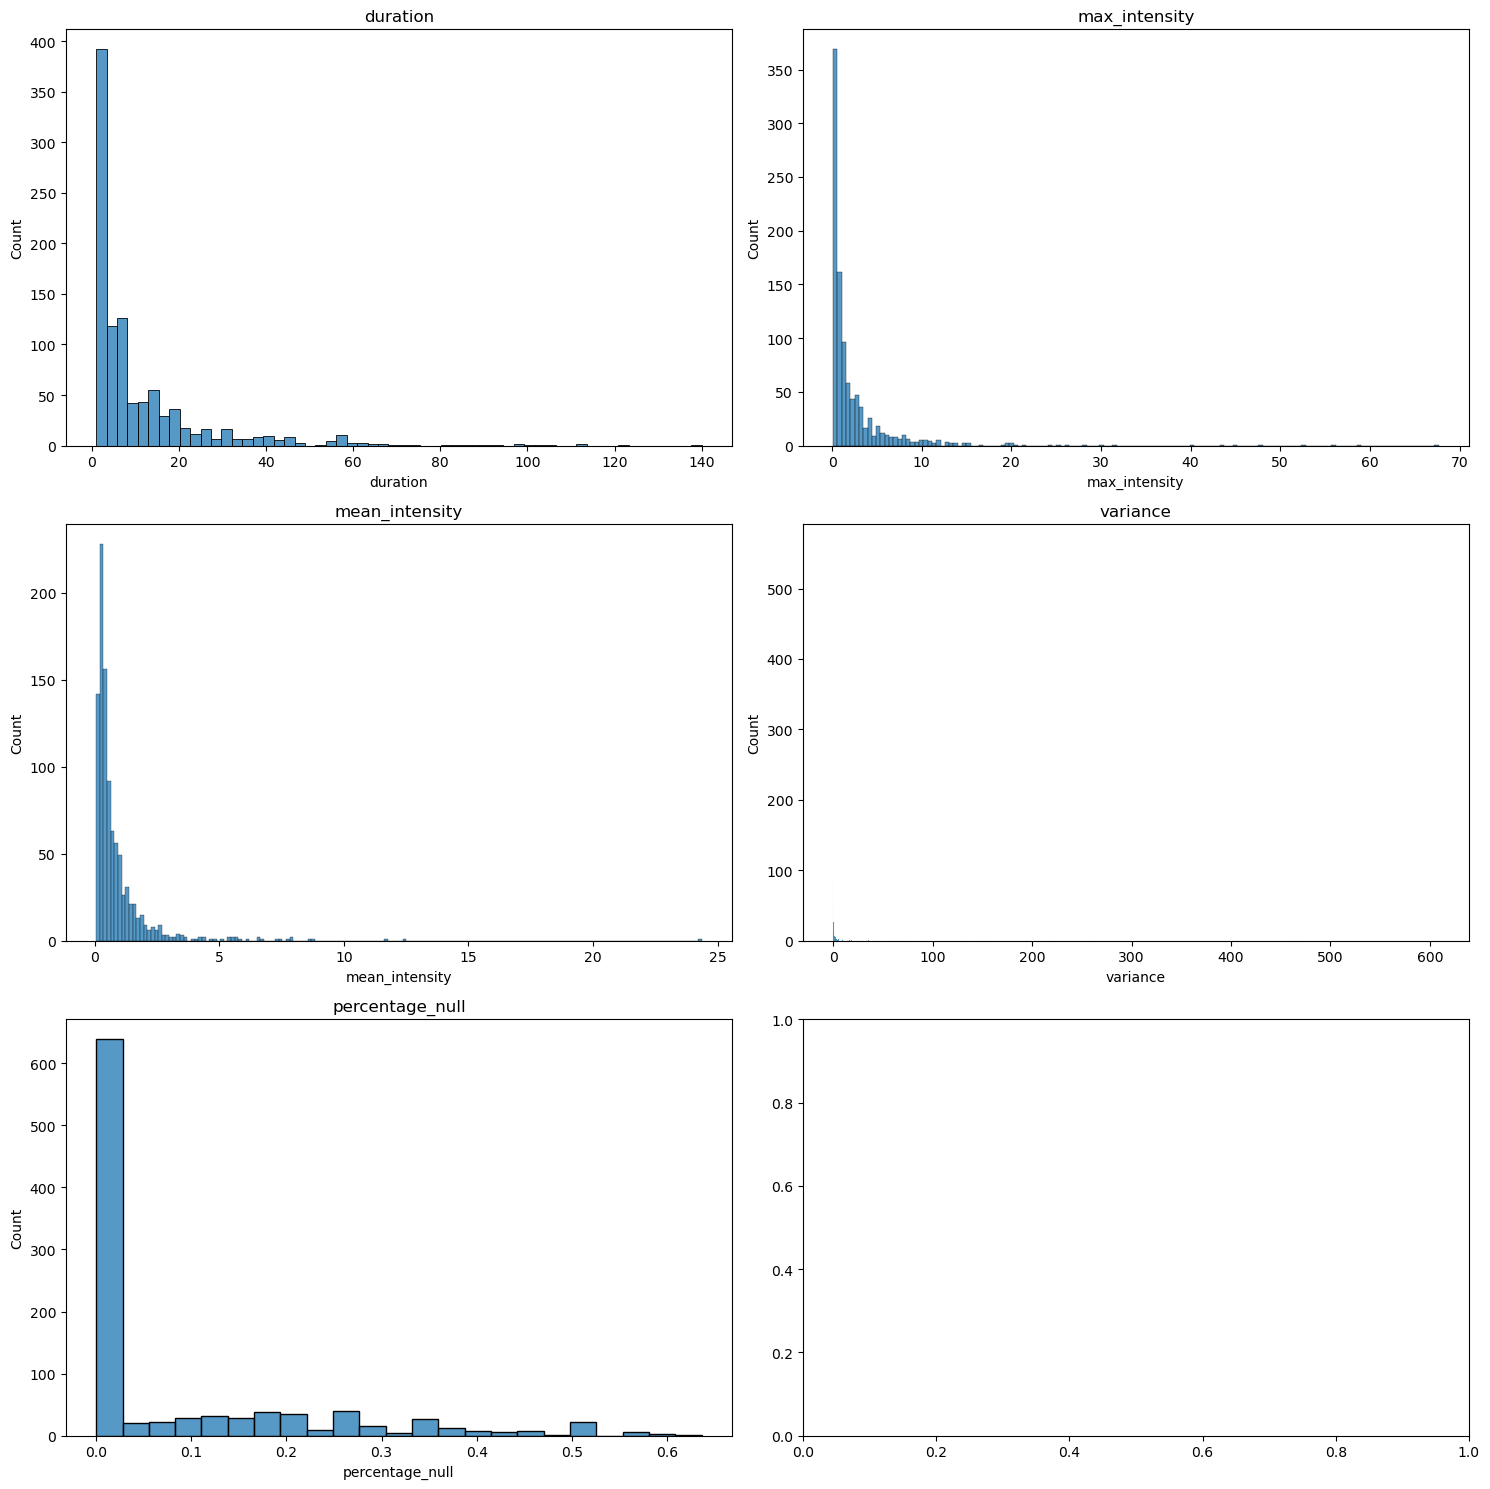

In [8]:
# plot the distribution of the features in the sample

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, feature in enumerate(features_list):
    sns.histplot(data_sample[feature], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(feature)

plt.tight_layout()

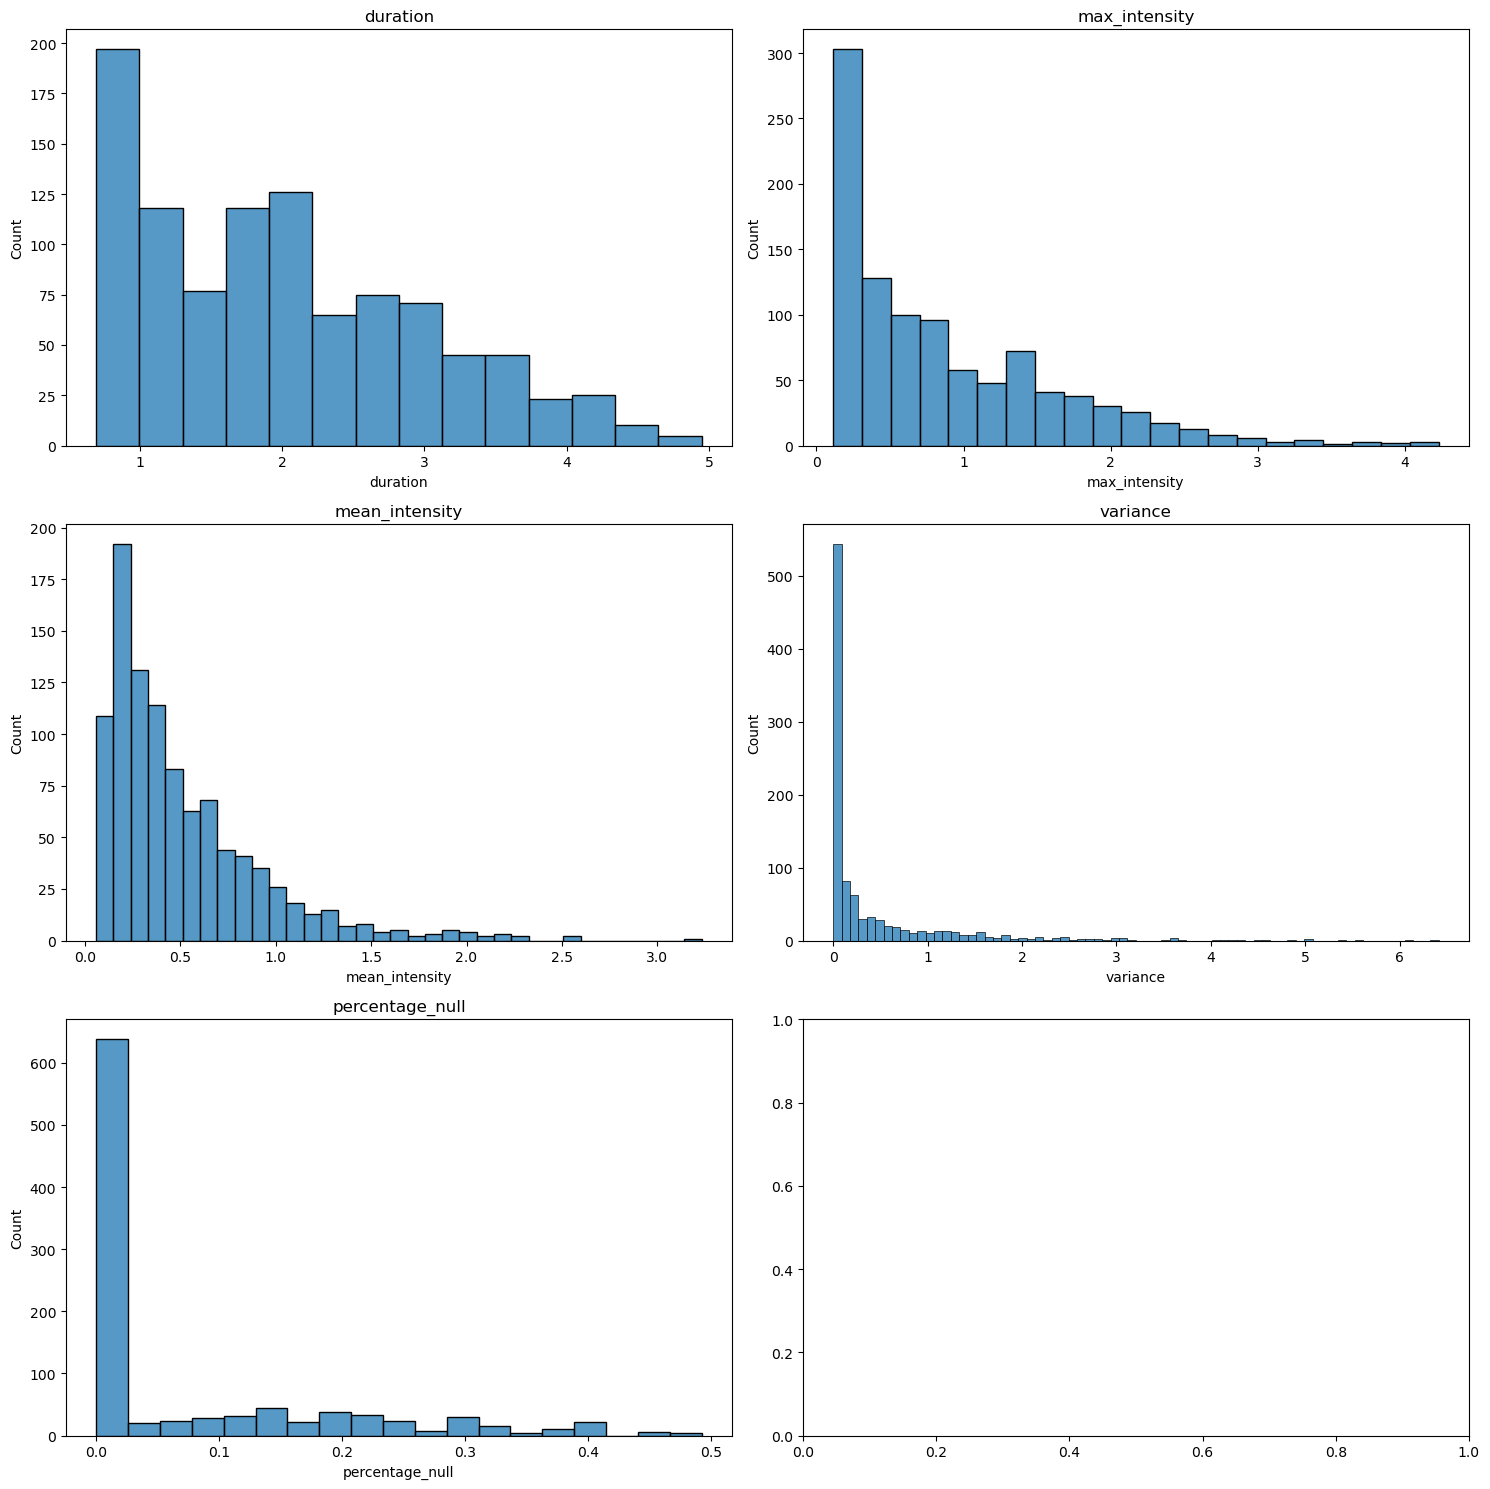

In [9]:
# apply the log transformation to the features

import numpy as np
import seaborn as sns

for feature in features_list:
    data_sample[feature] = np.log(data_sample[feature] + 1)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for i, feature in enumerate(features_list):
    sns.histplot(data_sample[feature], ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(feature)

plt.tight_layout()



<Axes: xlabel='duration', ylabel='max_intensity'>

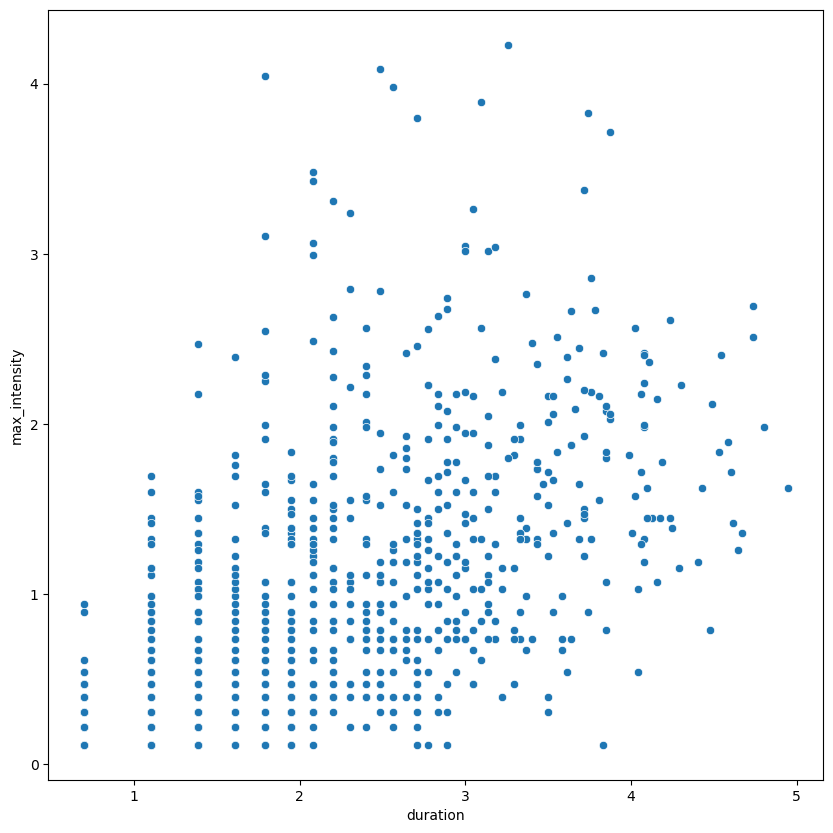

In [10]:
# plot duration vs max_intensity

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data=data_sample, x='duration', y='max_intensity', ax=ax)

c:\Users\Benjamin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Benjamin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


<Axes: xlabel='duration', ylabel='max_intensity'>

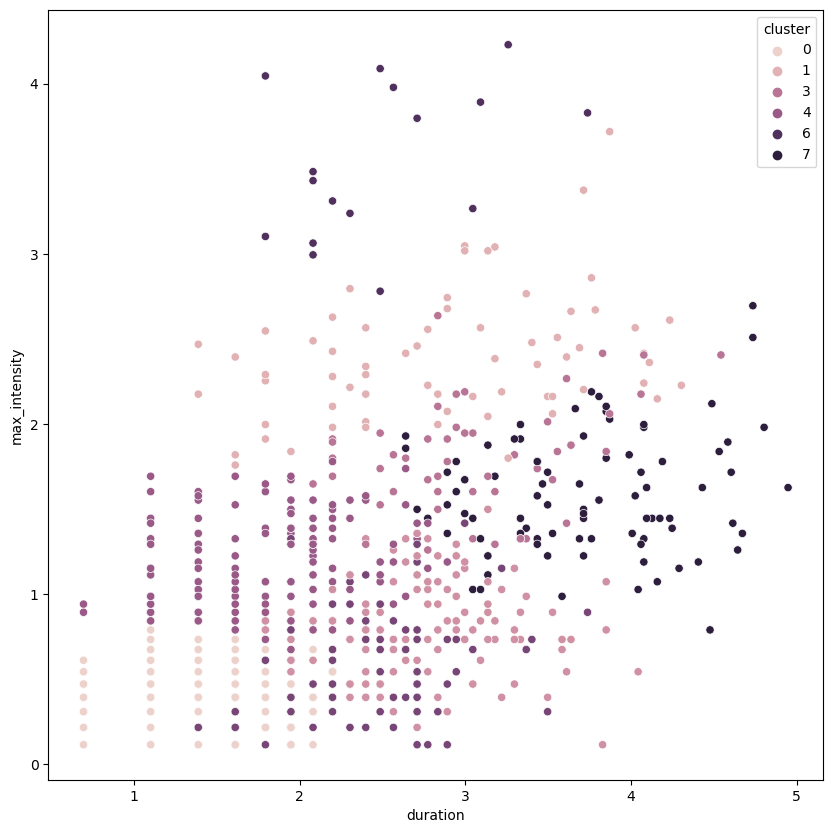

In [11]:
# cluster using k-means, standardize the data first

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_sample_scaled = scaler.fit_transform(data_sample)

kmeans = KMeans(n_clusters=8, random_state=0)

data_sample['cluster'] = kmeans.fit_predict(data_sample_scaled)

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data=data_sample, x='duration', y='max_intensity', hue='cluster', ax=ax)


<Axes: xlabel='cluster', ylabel='count'>

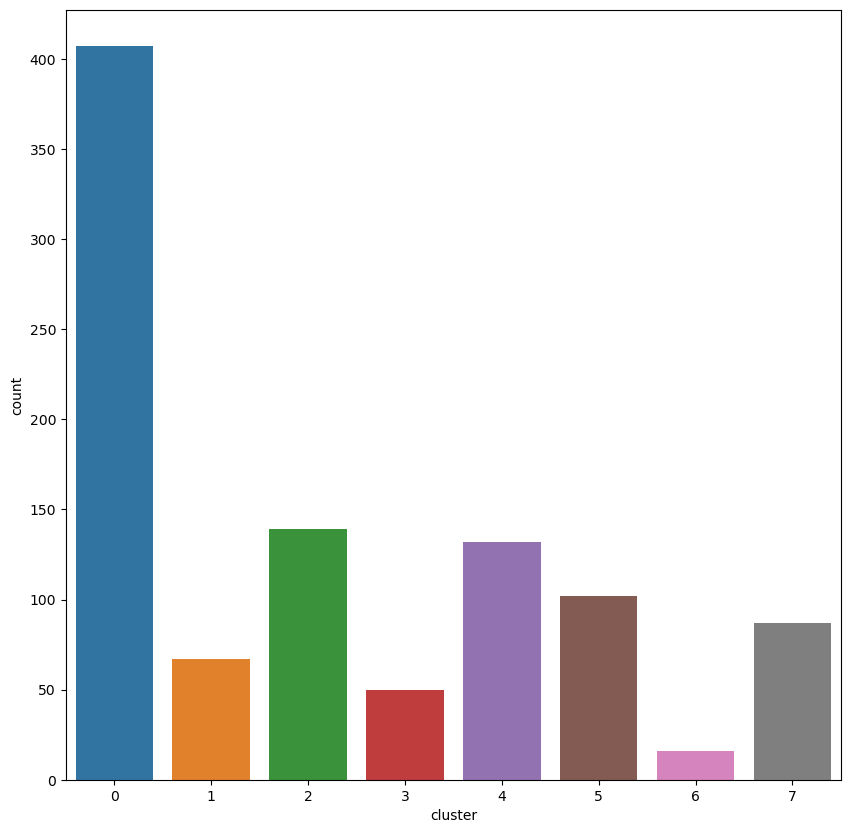

In [12]:
# plot cluster cardinality

fig, ax = plt.subplots(figsize=(10, 10))

sns.countplot(data=data_sample, x='cluster', ax=ax)

<Axes: xlabel='cluster', ylabel='distance'>

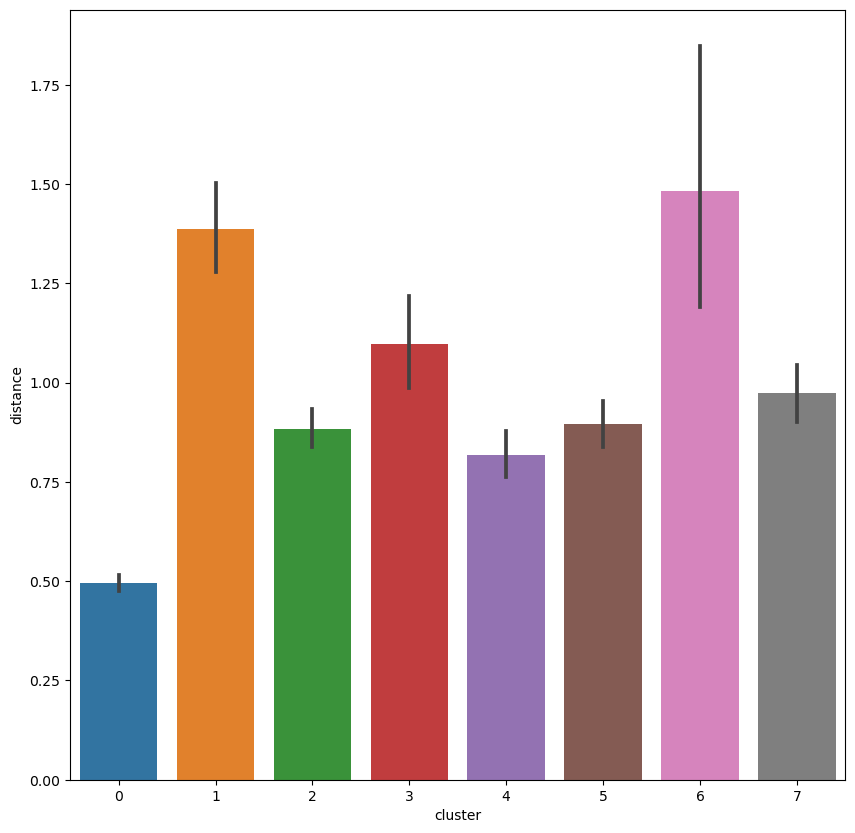

In [13]:
#cluster magnitude (sum of distances from the centroid)

data_sample['distance'] = kmeans.transform(data_sample_scaled).min(axis=1)

fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(data=data_sample, x='cluster', y='distance', ax=ax)

In [14]:
data['cluster'] = kmeans.predict(scaler.transform(data[features_list]))

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_26640\3125164507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = kmeans.predict(scaler.transform(data[features_list]))


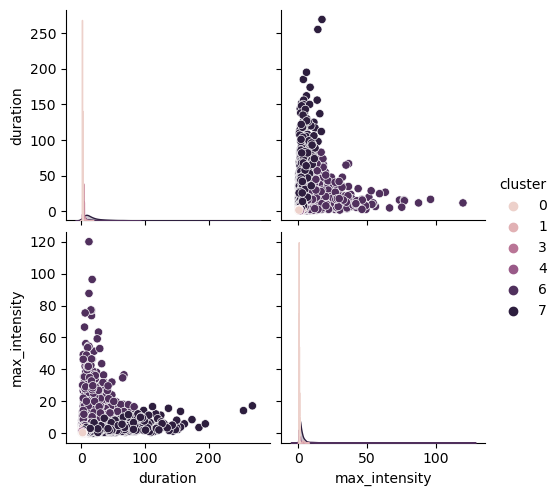

In [15]:
# Pairplot to visualize relationships between 'length', 'i', 'j', and cluster categories
sns.pairplot(data.sample(frac=0.1), hue='cluster', vars=['duration', 'max_intensity'])
plt.show()


In [16]:
# connect to the database and select 2018 july from events

conn = sqlite3.connect('precip.db')

query = f"SELECT * FROM events WHERE year = 2018 AND month BETWEEN 6 AND 8;"

df_july = pd.read_sql_query(query, conn)

conn.close()

In [70]:
from src.utils import read_data

read_data(2018, 5, 9).shape

(288, 300, 300)

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime

def read_data_range(start_year:int, start_month:int, start_day:int, 
                    end_year:int, end_month:int, end_day:int, 
                    pixel_i:int, pixel_j:int, 
                    treshold:float=1e-3) -> np.ndarray:
    start_date = datetime(start_year, start_month, start_day)
    end_date = datetime(end_year, end_month, end_day)
    date_range = pd.date_range(start_date, end_date)
    
    res = np.array([])  # List to hold data values from the specific pixel
    
    for date in date_range:
        path = f'data/raw_data/{date.year:04d}/'
        file_name = f'RR_IDF300x300_{date.year:04d}{date.month:02d}{date.day:02d}.npy'
        full_path = path + file_name
        try:
            raw_data = np.load(full_path) / 100.0  # Assuming the data needs to be scaled
            raw_data[raw_data < 0] = np.nan
        except FileNotFoundError:
            print(f"Warning: The file {full_path} does not exist. Skipping.")
            continue  # Skip this date if file not found
        
        """# Process threshold
        if raw_data[pixel_i, pixel_j] < treshold:
            value = 0
        else:"""
        
        value = raw_data[:,pixel_i, pixel_j]
        
        # Append the value at the specified pixel to the list
        res = np.concatenate((res, value), axis=None)
    
    # Convert the list of values into a NumPy array
    
    return res

# Example usage
# pixel_data = read_data_range(2022, 7, 1, 2022, 7, 10, 150, 150)


In [33]:
# read the data for the period 2018-05-01 to 2018-09-30

ts = read_data_range(2018, 6, 1, 2018, 8, 30, 150, 150)

In [19]:
df_july['cluster'] = kmeans.predict(scaler.transform(df_july[features_list]))

In [20]:
df_july

,year,month,day,i,j,start_time_relative,end_time_relative,start_time_absolute,end_time_absolute,duration,max_intensity,mean_intensity,variance,percentage_null,cluster
0,2018,6,1,0,21,19,19,19,19,1,0.12,0.120000,0.000000,0.000000,0
1,2018,6,1,0,22,18,19,18,19,2,0.36,0.360000,0.000000,0.000000,0
2,2018,6,1,0,23,17,19,17,19,3,0.60,0.400000,0.022400,0.000000,2
3,2018,6,1,0,24,16,18,16,18,3,1.08,0.680000,0.118400,0.000000,4
4,2018,6,1,0,25,16,18,16,18,3,1.56,1.000000,0.195200,0.000000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275575,2018,8,31,299,263,68,85,8708,8725,18,9.60,2.266111,6.755546,0.111111,6
7275576,2018,8,31,299,264,73,85,8713,8725,13,4.68,1.218462,1.306736,0.000000,7
7275577,2018,8,31,299,265,73,85,8713,8725,13,0.96,0.498462,0.068336,0.000000,7
7275578,2018,8,31,299,266,74,86,8714,8726,13,1.08,0.295385,0.074471,0.076923,7


In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plot_time_series_with_event(ts, events):

    # Generate a time array that represents each time point in hours from 0 to 24
    time = np.linspace(0, 24*len(ts)/288, num=len(ts), endpoint=False)

    plt.figure(figsize=(12, 6))
    plt.plot(time, ts, label='Time Series')  # Use 'time' as x-axis data

    color_map = {
        0: 'red',
        1: 'green',
        2: 'blue',
        3: 'purple',
        4: 'orange',
        5: 'brown',
        6: 'pink',
        7: 'gray',
    }

    # Highlight each event with a shaded area
    for start, end, cluster in zip(list(events['start_time_absolute']), list(events['end_time_absolute']), list(events['cluster'])):
        try:
            color = color_map.get(cluster, 'yellow') # default yellow
            plt.axvspan(time[start], time[end+1], color=color, alpha=0.3)
        except:
            pass

    # Setting up x-axis ticks to appear every 30 minutes with formatted labels
    #half_hour_ticks = np.arange(0, 24 + 1, 1)  # Create ticks every 0.5 hours
    #half_hour_labels = [f"{int(tick):02d}:{int((tick % 1) * 60):02d}" for tick in half_hour_ticks]  # Format as HH:MM
    #plt.xticks(half_hour_ticks, half_hour_labels, fontsize=8)  # Set x-ticks every 30 minutes with smaller font size

    # Adding labels and title for clarity
    plt.xlabel('Temps')
    plt.ylabel('Pluie (mm)')
    plt.title('Série de pluie en (150, 150) avec les événements')
    plt.grid(True)
    plt.show()


In [65]:
events = df_july[(df_july['i'] == 150) & (df_july['j'] == 150)]

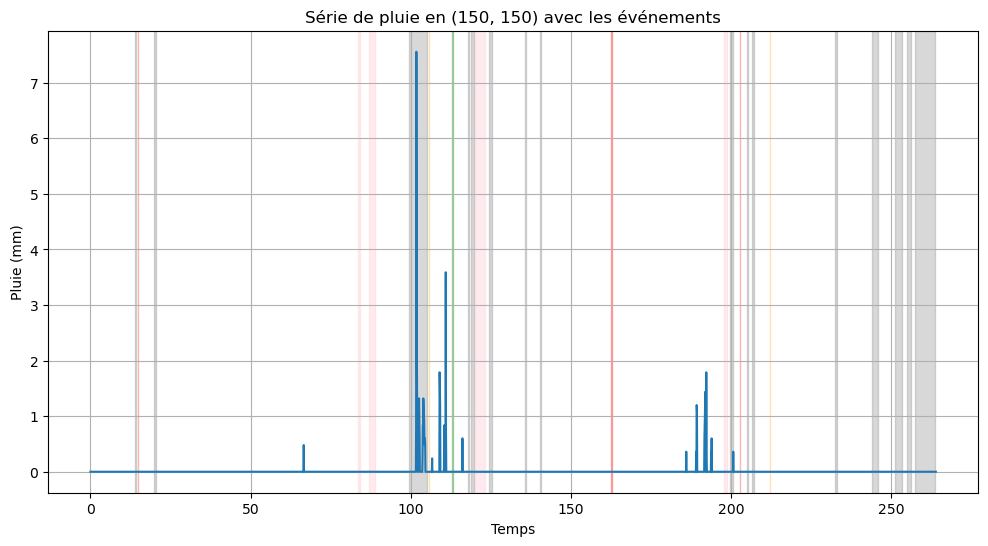

In [70]:
plot_time_series_with_event(ts, events)

In [78]:
events

,year,month,day,i,j,start_time_relative,end_time_relative,start_time_absolute,end_time_absolute,duration,max_intensity,mean_intensity,variance,percentage_null,cluster
30188,2018,6,1,150,150,166,169,166,169,4,1.44,0.870000,0.269100,0.000000,7
30189,2018,6,1,150,150,178,179,178,179,2,0.48,0.360000,0.014400,0.000000,0
312816,2018,6,4,150,150,180,201,1044,1065,22,24.96,6.021818,79.088251,0.000000,6
499377,2018,6,5,150,150,42,109,1194,1261,68,5.16,1.088529,1.388613,0.161765,7
499378,2018,6,5,150,150,117,117,1269,1269,1,0.96,0.960000,0.000000,0.000000,4
499379,2018,6,5,150,150,202,204,1354,1356,3,3.72,1.520000,2.422400,0.000000,1
499380,2018,6,5,150,150,263,265,1415,1417,3,1.20,0.760000,0.118400,0.000000,7
499381,2018,6,5,150,150,275,285,1427,1437,11,1.68,0.752727,0.173038,0.000000,7
795573,2018,6,6,150,150,0,37,1440,1477,38,9.84,2.418684,5.219717,0.105263,6
795574,2018,6,6,150,150,54,65,1494,1505,12,4.08,1.450000,1.976300,0.083333,7


In [77]:
ts[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [67]:
# read the data for the period 2018-05-01 to 2018-09-30

ts = read_data_range(2018, 8, 5, 2018, 8, 15, 150, 150)

In [53]:
dfb = df_july[(df_july['i'] == 150) & (df_july['j'] == 150) & (df_july['month'] == 8) & (df_july['day'] >= 5) & (df_july['day'] <= 15)]

IndexError: index 3384 is out of bounds for axis 0 with size 3168

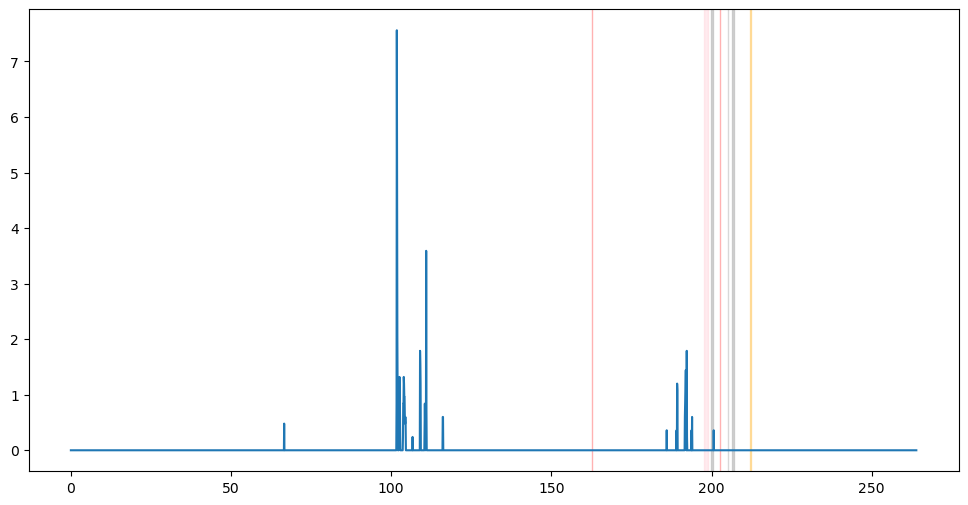

In [54]:
plot_time_series_with_event(ts, dfb)